# Session 2 - Parameter Calibration

Usually, the parameters we obtain from the characterization of the cell result is simulations that are off from cycling data. Therefore, before using a model, it is good practice to carry out a "Calibration" step, where we fit a small subset of the model parameters to experimental voltage profiles of the same cell.

In this session, we will calibrate the Xu 2025 parameter set to experimental voltage curves from the same cell. 

Let's import BattMo and some other packages we will use.

In [7]:
using BattMo, GLMakie, CSV, DataFrames, Jutul

GLMakie.activate!(inline=true)

### Load the experimental data

We will calibrate our model in two steps: 
1. We will adjust the stoichiometric coefficients and maximum concentrations of the active materials, to fit a cell voltage curve at C/2.
2. We will adjust the reaction rate constants and diffusion coefficients in the active materials, to fit a cell voltage curve at 2C.

We first load the datasets.

In [8]:
expdata_05C = CSV.read("Xu2015_data/Xu_2015_voltageCurve_05C.csv", DataFrame)
expdata_1C = CSV.read("Xu2015_data/Xu_2015_voltageCurve_1C.csv", DataFrame)
expdata_2C = CSV.read("Xu2015_data/Xu_2015_voltageCurve_2C.csv", DataFrame)

Row,t,V
,Float64,Float64
1,0.0,3.20968
2,110.725,3.15128
3,246.598,3.10993
4,394.822,3.10201
5,543.047,3.10273
6,691.272,3.10037
7,839.497,3.07889
8,963.018,3.05584
9,1086.54,3.00935


### Run a simulation of the original parameters
Now we run a baseline simulation using the parameters obtained only from characterization of the cell. We load the parameter set, ensure an appropiate lower voltage limit and DRate, and run the simulation as we saw in previous tutorials.

In [9]:
cell_parameters_original = load_cell_parameters(; from_default_set = "Xu2015")
cycling_protocol = load_cycling_protocol(; from_default_set = "CCDischarge")

cycling_protocol["LowerVoltageLimit"] = 2.25
model_setup = LithiumIonBattery()

cycling_protocol["DRate"] = 0.5
sim_original = Simulation(model_setup, cell_parameters_original, cycling_protocol)
output_original = solve(sim_original);


✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress   1%|█                                          |  ETA: 0:15:35

Progress  27%|████████████                               |  ETA: 0:00:32

Progress  43%|███████████████████                        |  ETA: 0:00:16

Progress  60%|██████████████████████████                 |  ETA: 0:00:08

Progress  76%|█████████████████████████████████          |  ETA: 0:00:04

Progress 100%|███████████████████████████████████████████| Time: 0:00:12


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 138 steps │ 138 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.18841 │       2.18841 │  302 (0) │
│ Linearization  │   3.18841 │       3.18841 │  440 (0) │
│ Linear solver  │   2.18841 │       2.18841 │  302 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬─────────┬────────────┬─────────╮
│ Timing type   │    Each │   Relative │   Total │
│               │      ms │ Percentage │       s │
├───────────────┼─────────┼────────────┼─────────┤
│ Properties    │  0.4679 │     1.18 % │  0.1413 │
│ Equations     │ 16.0226 │    58.90 % │  7.0499 │
│ Assembly      │  1.8696 │     6.87 % │  0.8226 │
│ Linear solve  │  0.6868 │     1.73 % │  0.2074 │
│ Linear setup  │  0.0000 │     0.00 % │  0.0000 │
│ Precond apply │  

Once the simulation completes, we can inspect the resutling voltage curves, and compare them with the experimental voltage curves.

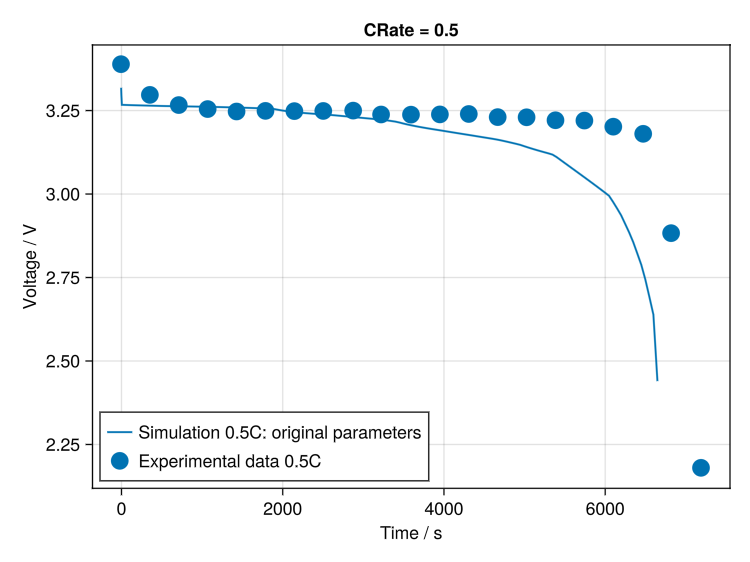

In [10]:
#Simulation data
time_series = get_output_time_series(output_original)
simdata_time_original = time_series[:Time]
simdata_voltage_original = time_series[:Voltage]

#Plot
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5", xlabel = "Time / s", ylabel = "Voltage / V")
lines!(ax, simdata_time_original, simdata_voltage_original, label = "Simulation 0.5C: original parameters")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 20)
axislegend(position = :lb)
fig

We can see that the simulation with original parameters does not match well the experiment. Lets therefore fit some parameters to the experimental data.

# Low-rate Calibration
### Set up the low-rate calibration

We have developed a calibration function that takes as inputs the voltage and time arrays of the data, along with the initial simulation setup.

In [ ]:
calibration_low_rate = VoltageCalibration(expdata_05C[:,1], expdata_05C[:,2], sim_original); #  VoltageCalibration(experimental_time, experimental_voltage, simulation)

VoltageCalibration([0.0, 357.76627218934914, 715.9763313609469, 1074.1863905325445, 1432.396449704142, 1790.6065088757396, 2148.816568047337, 2507.0266272189347, 2877.5887573964496, 3223.44674556213  …  3952.2189349112427, 4310.42899408284, 4668.639053254437, 5026.8491124260345, 5385.059171597633, 5743.2692307692305, 6101.479289940828, 6472.041420118343, 6817.899408284024, 7188.461538461537], [3.3861097472267683, 3.2943262673632967, 3.2638600156322126, 3.2518999695748874, 3.2446281622882482, 3.246486083133996, 3.245753135185418, 3.246253934281757, 3.2472569925301102, 3.2356583102522136  …  3.2359284205519883, 3.237169467875278, 3.227800290612279, 3.2273140920726844, 3.2184384136276525, 3.217458716270091, 3.1992065602836877, 3.177878797019038, 2.8807910485472883, 2.179051790010771], Simulation(BattMo.run_battery, LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D 

This calibration object is a handy way to tailor the main settings needed to run a calibration: 
* Which model parameters are frozen
* Which model parameters are being fitted
* What are the minimum and maximum bounds of the parameters to be fitted
* The results of the calibration, i.e. the optimal parameters.

All paremters are forzen by default, so we now need to free those we are interested in, and apply some bounds to each to ensure they remain within expected ranges. Below, we free the stoichiometric coefficients and maximum concentrations.

In [ ]:
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)

# "StoichiometricCoefficientAtSOC0" at both electrodes
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)

#  "MaximumConcentration" of both electrodes
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5);

VoltageCalibration([0.0, 357.76627218934914, 715.9763313609469, 1074.1863905325445, 1432.396449704142, 1790.6065088757396, 2148.816568047337, 2507.0266272189347, 2877.5887573964496, 3223.44674556213  …  3952.2189349112427, 4310.42899408284, 4668.639053254437, 5026.8491124260345, 5385.059171597633, 5743.2692307692305, 6101.479289940828, 6472.041420118343, 6817.899408284024, 7188.461538461537], [3.3861097472267683, 3.2943262673632967, 3.2638600156322126, 3.2518999695748874, 3.2446281622882482, 3.246486083133996, 3.245753135185418, 3.246253934281757, 3.2472569925301102, 3.2356583102522136  …  3.2359284205519883, 3.237169467875278, 3.227800290612279, 3.2273140920726844, 3.2184384136276525, 3.217458716270091, 3.1992065602836877, 3.177878797019038, 2.8807910485472883, 2.179051790010771], Simulation(BattMo.run_battery, LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D 

We have a handy function to check parameter, values and bounds:

In [13]:
print_calibration_overview(calibration_low_rate)

NegativeElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┐
│                                             Name │ Initial value │             Bounds │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┤
│              ActiveMaterial.MaximumConcentration │         31540 │ 10000.0 - 100000.0 │
│ ActiveMaterial.StoichiometricCoefficientAtSOC100 │      0.518738 │          0.0 - 1.0 │
│   ActiveMaterial.StoichiometricCoefficientAtSOC0 │         0.001 │          0.0 - 1.0 │
└──────────────────────────────────────────────────┴───────────────┴────────────────────┘
PositiveElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┐
│                                             Name │ Initial value │             Bounds │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┤
│ 

### Solve the low-rate calibration

Solving the calibration problem is essentially an optimization problem. We adjust free parameters so to minimize the difference between a target (the data) and the prediction (the simulation result): is performed by solving the optimization problem. This makes use of the adjoint method implemented in Jutul.jl and the LBFGS algorithm.

For calibration, we minimize the squared difference between the predicted and observed voltage, summed over all time steps:  
                  $\sum_i (V_i - V_{exp,i})^2$  
where $V_i$ is the voltage from the model and $V_{exp,i}$ is the voltage from the experimental data at step $i$. This minimization uses in the background cool algorithms implemented in Jutul, the simulation engine of BattMo. 

In [14]:
solve(calibration_low_rate);
cell_parameters_calibrated_low_rate = calibration_low_rate.calibrated_cell_parameters;

Calibration: Starting calibration of 6 parameters.
It:   0 | val: 3.909e-02 | ls-its: NaN | pgrad: 6.481e+00
It:   1 | val: 1.851e-02 | ls-its: 1 | pgrad: 6.480e+00
It:   2 | val: 4.544e-03 | ls-its: 4 | pgrad: 1.096e+00
It:   3 | val: 4.501e-03 | ls-its: 2 | pgrad: 1.380e-01
It:   4 | val: 4.498e-03 | ls-its: 1 | pgrad: 2.240e-02
It:   5 | val: 4.496e-03 | ls-its: 1 | pgrad: 1.533e-02
It:   6 | val: 4.484e-03 | ls-its: 1 | pgrad: 1.563e-02
It:   7 | val: 4.464e-03 | ls-its: 1 | pgrad: 5.439e-02
It:   8 | val: 4.308e-03 | ls-its: 1 | pgrad: 7.927e-02
LBFGS: Line search unable to succeed in 5 iterations ...
LBFGS: Hessian not updated during iteration 9
It:   9 | val: 3.263e-03 | ls-its: 5 | pgrad: 2.390e-01
LBFGS: Line search unable to succeed in 5 iterations ...
LBFGS: Hessian not updated during iteration 10
It:  10 | val: 3.263e-03 | ls-its: 5 | pgrad: 2.759e-01
Calibration: Calibration finished in 256.4078808 seconds.


We can use the same printing function to explore the results of the simulation

In [15]:
print_calibration_overview(calibration_low_rate)

NegativeElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┬─────────────────┬──────────┐
│                                             Name │ Initial value │             Bounds │ Optimized value │   Change │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┼─────────────────┼──────────┤
│              ActiveMaterial.MaximumConcentration │         31540 │ 10000.0 - 100000.0 │         22255.0 │  -29.44% │
│ ActiveMaterial.StoichiometricCoefficientAtSOC100 │      0.518738 │          0.0 - 1.0 │        0.545878 │    5.23% │
│   ActiveMaterial.StoichiometricCoefficientAtSOC0 │         0.001 │          0.0 - 1.0 │       0.0263973 │ 2539.73% │
└──────────────────────────────────────────────────┴───────────────┴────────────────────┴─────────────────┴──────────┘
PositiveElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬─

### Compare the results of the calibration against the experimental data

We can now use the optimized parameters to run a new simulation, and compare the results to the experimental data for the 0.5C discharge curve.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  13%|██████                                     |  ETA: 0:00:01

Progress  34%|███████████████                            |  ETA: 0:00:00

Progress  54%|████████████████████████                   |  ETA: 0:00:00

Progress  73%|████████████████████████████████           |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 145 steps │ 145 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.12414 │       2.12414 │  308 (0) │
│ Linearization  │   3.12414 │       3.12414 │  453 (0) │
│ Linear solver  │   2.12414 │       2.12414 │  308 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.3631 │    20.16 % │ 111.8196 │
│ Equations     │ 0.2708 │    22.12 % │ 122.6709 │
│ Assembly      │ 0.1139 │     9.30 % │  51.5746 │
│ Linear solve  │ 0.4206 │    23.36 % │ 129.5323 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

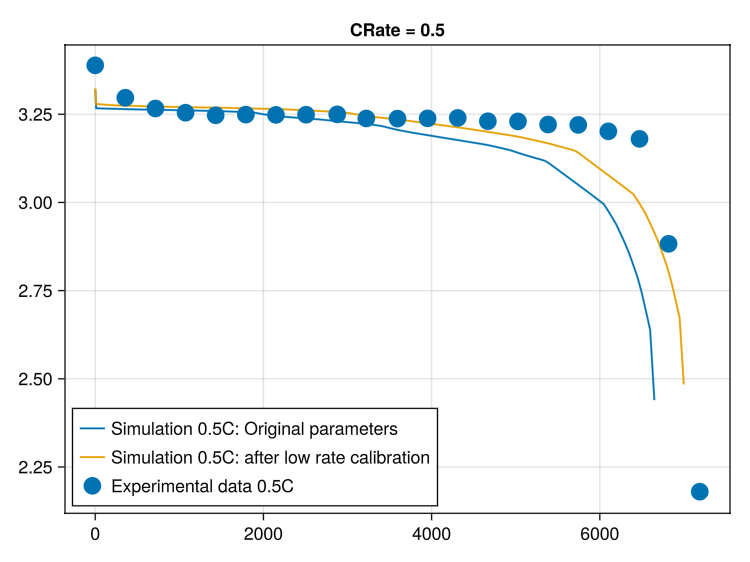

In [16]:
#Setup and run simulation
sim_calibrated_low_rate = Simulation(model_setup, cell_parameters_calibrated_low_rate, cycling_protocol)
output_calibrated_low_rate = solve(sim_calibrated_low_rate);

#Get simulation data
time_series = get_output_time_series(output_calibrated_low_rate)
simdata_time_calibrated_low_rate = time_series[:Time]
simdata_voltage_calibrated_low_rate = time_series[:Voltage]

#Plot
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5")
lines!(ax, simdata_time_original, simdata_voltage_original, label = "Simulation 0.5C: Original parameters")
lines!(ax, simdata_time_calibrated_low_rate, simdata_voltage_calibrated_low_rate, label = "Simulation 0.5C: after low rate calibration")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 20)
axislegend(position = :lb)
fig

# High-rate Calibration
### Set up the high-rate calibration

The second calibration is performed against the 2.0C discharge curve. In the same manner as for the first discharge curve, we set up a set of parameters to calibrate against experimental data. The parameters are:

 - The reaction rate constant of both electrodes
 - The diffusion coefficient of both electrodes

The calibration this time starts from the parameters calibrated at 0.5C, so we use the `cell_parameters_calibrated_05C` from the first `solve` to run a new simulation at 2C:

In [17]:
#Update cycling protocol to run at 2C
cycling_protocol2 = deepcopy(cycling_protocol)
cycling_protocol2["DRate"] = 2.0

#Solve simulation with parameters calibrated at 05C but running a 2C discharge protocol
sim_calibrated_low_rate = Simulation(model_setup, cell_parameters_calibrated_low_rate, cycling_protocol2)
output_calibrated_low_rate = solve(sim_calibrated_low_rate);

#Get simulation data of parameters calibrated at 0.5C but run at 2C
time_series = get_output_time_series(output_calibrated_low_rate)
simdata_time_calibrated_low_rate = time_series[:Time]
simdata_voltage_calibrated_low_rate = time_series[:Voltage]

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps


Progress  58%|█████████████████████████                  |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 34 steps │ 35 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.14706 │      3.05714 │  107 (3) │
│ Linearization  │  4.14706 │      4.02857 │  141 (3) │
│ Linear solver  │  3.11765 │      3.02857 │  106 (2) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.3612 │    10.60 % │  38.6521 │
│ Equations     │ 0.2589 │    10.01 % │  36.5035 │
│ Assembly      │ 0.1051 │     4.06 % │  14.8170 │
│ Linear solve  │ 0.7197 │    21.12 % │  77.0068 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

33-element Vector{Float64}:
 3.312258463255133
 3.242956241397714
 3.166360534467352
 3.1660391989581025
 3.165351465548032
 3.1641414159620673
 3.1631228625981493
 3.1619053862060875
 3.1603874185049494
 3.158724785652458
 ⋮
 3.033244200470778
 3.020515014938772
 3.0027660613299068
 2.9662889962498715
 2.928922783655243
 2.889907839253627
 2.8116188321912805
 2.688710256728714
 2.47484909419496

We use the simulation at 2C ran with the parameter set calibrated at 0.5C as a starting point for our new high rate calibration task. 

This time we free the reaction rate constants and diffusion coefficients, and set some boundaries for each.

In [19]:
calibration_high_rate = VoltageCalibration(expdata_2C[:,1], expdata_2C[:,2], sim_calibrated_low_rate)

free_calibration_parameter!(calibration_high_rate,
    ["NegativeElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)
free_calibration_parameter!(calibration_high_rate,
    ["PositiveElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)

free_calibration_parameter!(calibration_high_rate,
    ["NegativeElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)
free_calibration_parameter!(calibration_high_rate,
    ["PositiveElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)

print_calibration_overview(calibration_high_rate)

NegativeElectrode: Active calibration parameters
┌─────────────────────────────────────┬───────────────┬───────────────────┐
│                                Name │ Initial value │            Bounds │
├─────────────────────────────────────┼───────────────┼───────────────────┤
│ ActiveMaterial.DiffusionCoefficient │       3.9e-14 │ 1.0e-16 - 1.0e-12 │
│ ActiveMaterial.ReactionRateConstant │     1.764e-11 │ 1.0e-16 - 1.0e-10 │
└─────────────────────────────────────┴───────────────┴───────────────────┘
PositiveElectrode: Active calibration parameters
┌─────────────────────────────────────┬───────────────┬───────────────────┐
│                                Name │ Initial value │            Bounds │
├─────────────────────────────────────┼───────────────┼───────────────────┤
│ ActiveMaterial.ReactionRateConstant │     3.626e-11 │ 1.0e-16 - 1.0e-10 │
│ ActiveMaterial.DiffusionCoefficient │      1.25e-15 │ 1.0e-16 - 1.0e-12 │
└─────────────────────────────────────┴───────────────┴───────────

### Solve the high-rate calibration problem

In [20]:
cell_parameters_calibrated_high_rate, = solve(calibration_high_rate);
print_calibration_overview(calibration_high_rate)

Calibration: Starting calibration of 4 parameters.
It:   0 | val: 4.666e-02 | ls-its: NaN | pgrad: 3.384e+01
It:   1 | val: 3.623e-03 | ls-its: 1 | pgrad: 3.383e+01
It:   2 | val: 2.669e-03 | ls-its: 2 | pgrad: 4.312e-01
LBFGS: Line search at max step size, Wolfe conditions not satisfied for this step
LBFGS: Hessian not updated during iteration 3
It:   3 | val: 1.391e-03 | ls-its: 1 | pgrad: 2.582e-01
It:   4 | val: 1.328e-03 | ls-its: 1 | pgrad: 3.015e-01
It:   5 | val: 1.301e-03 | ls-its: 1 | pgrad: 5.217e-02
It:   6 | val: 1.259e-03 | ls-its: 1 | pgrad: 3.967e-02
It:   7 | val: 1.255e-03 | ls-its: 1 | pgrad: 1.023e-02
It:   8 | val: 1.230e-03 | ls-its: 2 | pgrad: 8.600e-03
It:   9 | val: 1.125e-03 | ls-its: 1 | pgrad: 8.498e-03
It:  10 | val: 9.833e-04 | ls-its: 1 | pgrad: 1.641e-02
It:  11 | val: 9.330e-04 | ls-its: 1 | pgrad: 1.527e-02
It:  12 | val: 9.301e-04 | ls-its: 1 | pgrad: 5.616e-03
It:  13 | val: 9.299e-04 | ls-its: 1 | pgrad: 2.053e-03
Calibration: Calibration finished i

### Compare the results of the high-rate calibration against the experimental data

We compare three simulations against the experimental data:
 1. The initial simulation with the original parameters.
 2. The simulation with the parameters calibrated against the 0.5C discharge curve.
 3. The simulation with the parameters calibrated against the 0.5C and 2.0C discharge curves.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps


Progress  36%|████████████████                           |  ETA: 0:00:00

Progress  67%|█████████████████████████████              |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 32 steps │ 33 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │   3.8125 │      3.69697 │  122 (3) │
│ Linearization  │   4.8125 │      4.66667 │  154 (3) │
│ Linear solver  │  3.78125 │      3.66667 │  121 (2) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.9975 │    35.89 % │ 121.6968 │
│ Equations     │ 0.3895 │    17.69 % │  59.9772 │
│ Assembly      │ 0.1654 │     7.51 % │  25.4679 │
│ Linear solve  │ 0.4007 │    14.42 % │  48.8909 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

Progress   9%|████                                       |  ETA: 0:00:01

Progress  62%|███████████████████████████                |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 39 steps │ 43 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.82051 │      3.46512 │ 149 (21) │
│ Linearization  │  4.87179 │       4.4186 │ 190 (22) │
│ Linear solver  │  3.76923 │       3.4186 │ 147 (19) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.4312 │    17.24 % │  64.2538 │
│ Equations     │ 0.3196 │    16.29 % │  60.7264 │
│ Assembly      │ 0.1353 │     6.89 % │  25.7013 │
│ Linear solve  │ 0.9307 │    37.20 % │ 138.6799 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

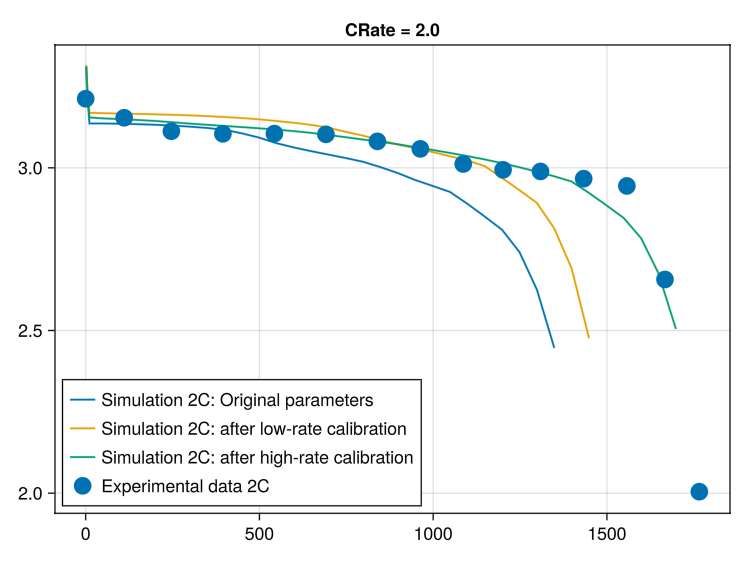

In [21]:
# Simulation at 2C  using original parameters
sim_original_params = Simulation(model_setup, cell_parameters_original, cycling_protocol2)
output_original_params = solve(sim_original_params, accept_invalid = false);
 
time_series = get_output_time_series(output_original_params)
simdata_time_original_params = time_series[:Time]
simdata_voltage_original_params = time_series[:Voltage]


# Simulation at 2C using calibrated parameters from 2C calibration
sim_calibrated_high_rate = Simulation(model_setup, cell_parameters_calibrated_high_rate, cycling_protocol2)
output_calibrated_high_rate = solve(sim_calibrated_high_rate, accept_invalid = false);
 
time_series = get_output_time_series(output_calibrated_high_rate)
simdata_time_calibrated_high_rate = time_series[:Time]
simdata_voltage_calibrated_high_rate = time_series[:Voltage]

# Plot 2C calibrated model vs 2C experimental data
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 2.0")
lines!(ax, simdata_time_original_params, simdata_voltage_original_params, label = "Simulation 2C: Original parameters")
lines!(ax, simdata_time_calibrated_low_rate, simdata_voltage_calibrated_low_rate, label = "Simulation 2C: after low-rate calibration")
lines!(ax, simdata_time_calibrated_high_rate, simdata_voltage_calibrated_high_rate, label = "Simulation 2C: after high-rate calibration")
scatter!(ax, expdata_2C[:,1], expdata_2C[:,2], label = "Experimental data 2C", markersize = 20)
axislegend(position = :lb)
fig

# Calibrated model at all CRates

We can now compare the results of the model after both low-rate and high-rate calibration against the experimental data for the 0.5C, 1.0C, and 2.0C discharge curves. 

> **Note that we did not calibrate the model for the 1.0C discharge curve, but we still obtain a good fit!!**

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  18%|████████                                   |  ETA: 0:00:01

Progress  31%|██████████████                             |  ETA: 0:00:01

Progress  43%|███████████████████                        |  ETA: 0:00:01

Progress  55%|████████████████████████                   |  ETA: 0:00:00

Progress  68%|██████████████████████████████             |  ETA: 0:00:00

Progress  80%|███████████████████████████████████        |  ETA: 0:00:00

Progress  92%|████████████████████████████████████████   |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 151 steps │ 151 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.15894 │       2.15894 │  326 (0) │
│ Linearization  │   3.15894 │       3.15894 │  477 (0) │
│ Linear solver  │   2.15894 │       2.15894 │  326 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.5409 │    19.30 % │ 176.3397 │
│ Equations     │ 0.3874 │    20.23 % │ 184.8097 │
│ Assembly      │ 0.1635 │     8.53 % │  77.9826 │
│ Linear solve  │ 0.6686 │    23.86 % │ 217.9638 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

Progress  28%|█████████████                              |  ETA: 0:00:00

Progress  62%|███████████████████████████                |  ETA: 0:00:00

Progress  91%|███████████████████████████████████████    |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 76 steps │ 76 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  2.46053 │      2.46053 │  187 (0) │
│ Linearization  │  3.46053 │      3.46053 │  263 (0) │
│ Linear solver  │  2.46053 │      2.46053 │  187 (0) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.7074 │    33.40 % │ 132.2805 │
│ Equations     │ 0.3212 │    21.33 % │  84.4685 │
│ Assembly      │ 0.1404 │     9.32 % │  36.9125 │
│ Linear solve  │ 0.3358 │    15.86 % │  62.7952 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

Progress  47%|█████████████████████                      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 39 steps │ 43 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.82051 │      3.46512 │ 149 (21) │
│ Linearization  │  4.87179 │       4.4186 │ 190 (22) │
│ Linear solver  │  3.76923 │       3.4186 │ 147 (19) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.3951 │    20.66 % │  58.8693 │
│ Equations     │ 0.3093 │    20.62 % │  58.7701 │
│ Assembly      │ 0.1253 │     8.35 % │  23.8054 │
│ Linear solve  │ 0.5935 │    31.03 % │  88.4283 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

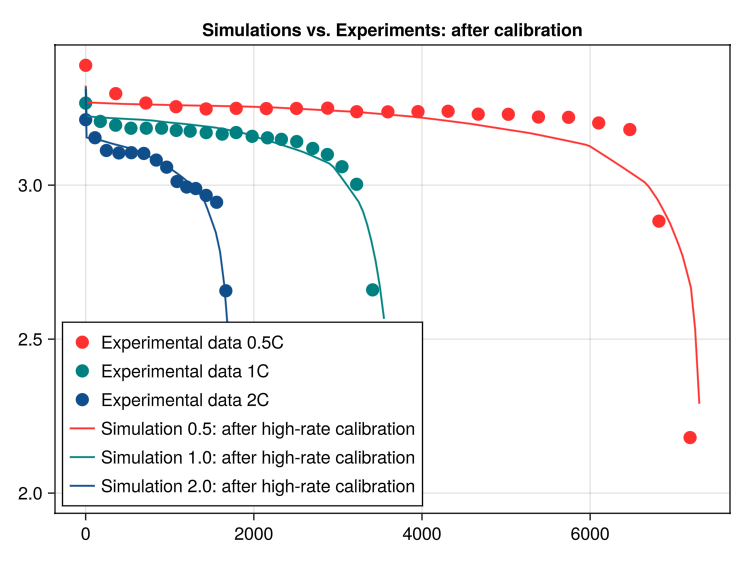

In [22]:
CRates = [0.5, 1.0, 2.0]
colors = Dict(0.5 => :firebrick1, 1.0 => :teal, 2.0 => :dodgerblue4)

fig = Figure()
ax = Axis(fig[1, 1], title = "Simulations vs. Experiments: after calibration")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 15, color = colors[0.5])
scatter!(ax, expdata_1C[:,1], expdata_1C[:,2], label = "Experimental data 1C", markersize = 15, color =colors[1.0])
scatter!(ax, expdata_2C[:,1], expdata_2C[:,2], label = "Experimental data 2C", markersize = 15, color =colors[2.0])

for CRate in CRates
    #Setup and run simulation
    cycling_protocol["DRate"] = CRate
    sim = Simulation(model_setup, cell_parameters_calibrated_high_rate, cycling_protocol)
    output = solve(sim, accept_invalid = false)

    #Get time series from simulation result
    time_series = get_output_time_series(output)
    t = time_series[:Time]
    V = time_series[:Voltage]

    #Plot simulation voltage response
    lines!(ax, t, V, label = "Simulation $CRate: after high-rate calibration", color = colors[CRate])
end  

axislegend(position = :lb)
fig